In [1]:
! pip install -q kaggle
import os
if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  from google.colab import files
  print("Upload kaggle.json here")
  files.upload()

if not os.path.isfile('IMDB Dataset.csv'):
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_name = 'kaustubhb999/tomatoleaf'
  zip_name = dataset_name.split('/')[-1]

  !kaggle datasets download -d {dataset_name}
  !unzip -q ./{zip_name}.zip -d .


In [2]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Set the path to your 'train' folder
train_folder = '/content/drive/MyDrive/tomato/train'

# Set the path to create 'test' folder
test_folder = '/content/drive/MyDrive/tomato/test'

# List all the classes in the 'train' folder
class_folders = [os.path.join(train_folder, c) for c in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, c))]

# Create the 'test' folder if it doesn't exist
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Loop through each class folder and split 100 images for testing
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

    # Get the list of images for the current class
    images = [os.path.join(class_folder, img) for img in os.listdir(class_folder)]

    # Ensure there are at least 100 images in the class folder
    if len(images) >= 100:
        # Split the images into training and testing sets
        train_images, test_images = train_test_split(images, test_size=100, random_state=42)

        # Create class folders in 'test' if they don't exist
        test_class_folder = os.path.join(test_folder, class_name)
        if not os.path.exists(test_class_folder):
            os.makedirs(test_class_folder)

        # Move images to the 'test' folder
        for test_image in test_images:
            shutil.move(test_image, os.path.join(test_class_folder, os.path.basename(test_image)))
    else:
        print(f"Skipping {class_name} as it has less than 100 images.")

print("Data split successfully!")


Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


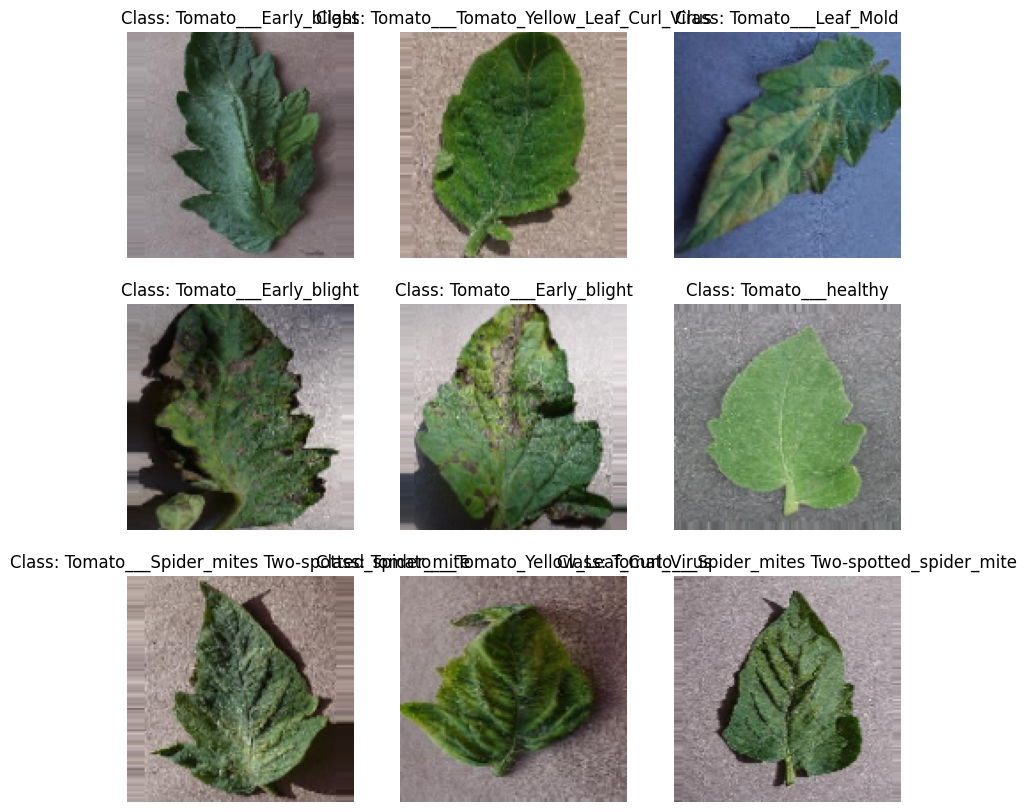

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


img_width, img_height = 128, 128
batch_size = 64
LearningRate = .0001
num_epochs = 40

train_dir = '/content/drive/MyDrive/tomato/train'
val_dir = '/content/drive/MyDrive/tomato/val'
test_dir = '/content/drive/MyDrive/tomato/test'
model_save_path = "tomato_leaf_disease_prediction.h5"



train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


#Visualize data before training
sample_images, sample_labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    class_index = np.argmax(sample_labels[i])
    class_name = class_names[class_index]
    plt.title(f'Class: {class_name}')
    plt.axis('off')
plt.show()


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

model.save(model_save_path)


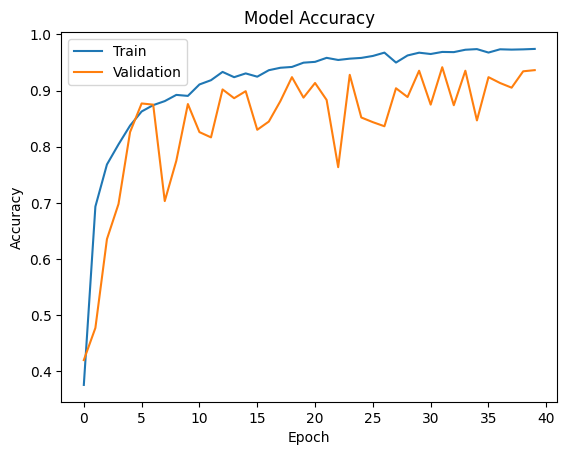

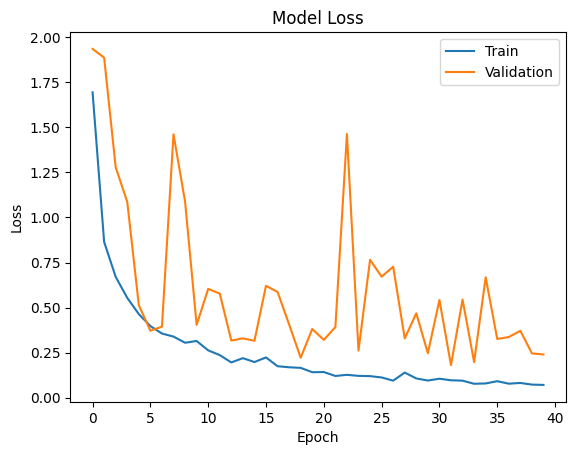

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


15/15 [==============================] - 4s 241ms/step - loss: 0.2678 - accuracy: 0.9354
Test Accuracy: 93.54%
Test Loss: 0.2678
2/2 [==============================] - 0s 10ms/step


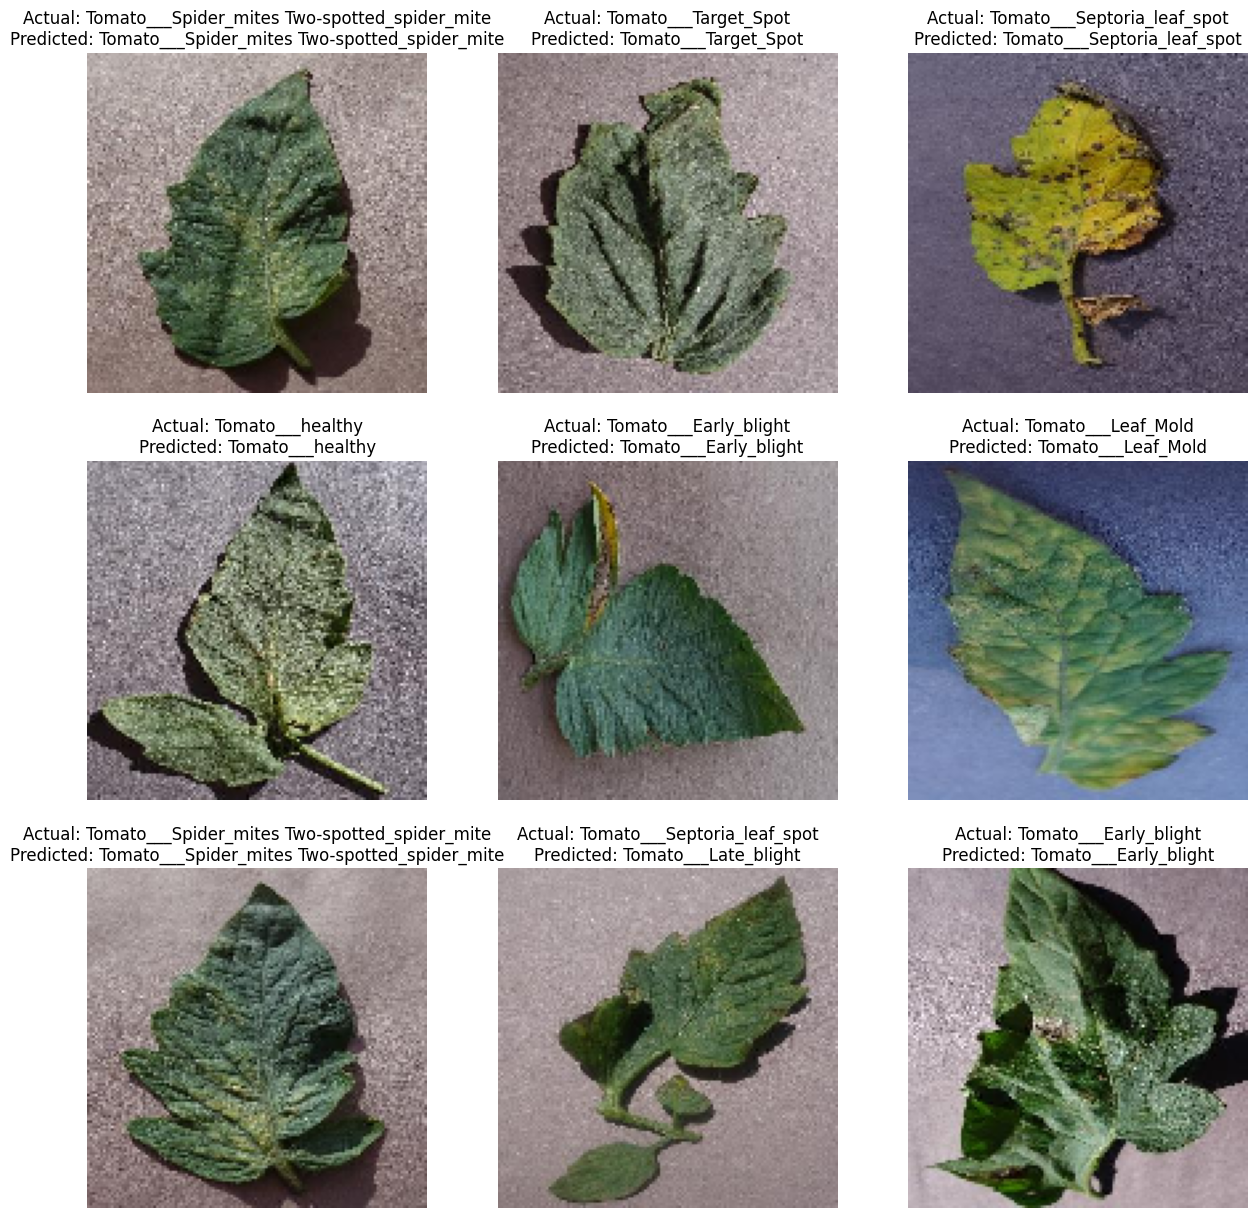

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Visualize predictions
num_samples = 9

test_images, test_labels = next(test_generator)
predicted_labels = model.predict(test_images)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 15))
for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])

    actual_class_index = np.argmax(test_labels[i])
    actual_class_name = class_names[actual_class_index]

    predicted_class_index = np.argmax(predicted_labels[i])
    predicted_class_name = class_names[predicted_class_index]

    title = f'Actual: {actual_class_name}\nPredicted: {predicted_class_name}'
    plt.title(title)
    plt.axis('off')

plt.show()